In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK setup
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load dataset
dataset = pd.read_csv(r'/content/Restaurant_Reviews.tsv',
                      delimiter='\t', quoting=3)

# Preprocessing
corpus = []
ps = PorterStemmer()

for i in range(len(dataset)):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

y = dataset['Liked'].values


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": LinearSVC(),
    "SVM (RBF)": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}


In [4]:
def evaluate_models(X, y, vectorizer_name):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((name, acc))
        print(f"🔹 {vectorizer_name} | {name}: {acc:.4f}")
        # Optional: print confusion matrix
        # print(confusion_matrix(y_test, y_pred))

    return pd.DataFrame(results, columns=["Model", f"Accuracy ({vectorizer_name})"])


🔹 BOW | Logistic Regression: 0.7100
🔹 BOW | Naive Bayes: 0.7650
🔹 BOW | SVM (Linear): 0.7150
🔹 BOW | SVM (RBF): 0.7300
🔹 BOW | KNN: 0.6450
🔹 BOW | Decision Tree: 0.6600
🔹 BOW | Random Forest: 0.7000
🔹 BOW | Gradient Boosting: 0.7400
🔹 BOW | XGBoost: 0.7200
[LightGBM] [Info] Number of positive: 397, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496250 -> initscore=-0.015000
[LightGBM] [Info] Start training from score -0.015000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

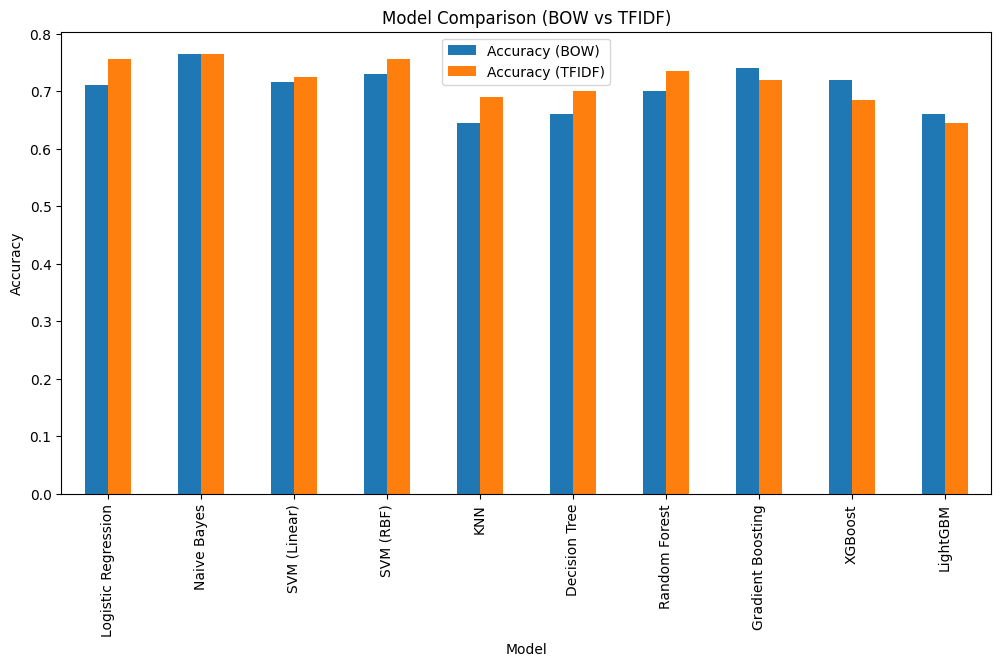

In [5]:
# Bag of Words
cv = CountVectorizer(max_features=2000)   # increased features for larger vocab
X_bow = cv.fit_transform(corpus).toarray()
bow_results = evaluate_models(X_bow, y, "BOW")

# TF-IDF
tfidf = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf.fit_transform(corpus).toarray()
tfidf_results = evaluate_models(X_tfidf, y, "TFIDF")

# Combine results
final_results = pd.merge(bow_results, tfidf_results, on="Model")
print("\n📊 Final Results:")
print(final_results)

# Plot
final_results.set_index("Model").plot(kind="bar", figsize=(12,6))
plt.title("Model Comparison (BOW vs TFIDF)")
plt.ylabel("Accuracy")
plt.show()


In [6]:
import numpy as np
import pandas as pd
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK setup
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)

# Load dataset
dataset = pd.read_csv(r'/content/Restaurant_Reviews.tsv',
                      delimiter='\t', quoting=3)

# Preprocessing
corpus = []
ps = PorterStemmer()
for i in range(len(dataset)):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

y = dataset['Liked'].values


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": LinearSVC(),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}


In [8]:
def evaluate_models(X, y, vectorizer_name):
    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring='f1').mean()
        prec = cross_val_score(model, X, y, cv=skf, scoring='precision').mean()
        rec = cross_val_score(model, X, y, cv=skf, scoring='recall').mean()
        roc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc').mean()

        results.append([name, acc, prec, rec, f1, roc])
        print(f"🔹 {vectorizer_name} | {name}: Acc={acc:.4f}, F1={f1:.4f}, ROC-AUC={roc:.4f}")

    return pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])


In [16]:
# Bag of Words
cv = CountVectorizer(max_features=3000)   # larger vocab
X_bow = cv.fit_transform(corpus).toarray()
bow_results = evaluate_models(X_bow, y, "BOW")

🔹 BOW | Logistic Regression: Acc=0.7930, F1=0.7899, ROC-AUC=0.8644
🔹 BOW | Naive Bayes: Acc=0.7710, F1=0.7804, ROC-AUC=0.8687
🔹 BOW | SVM (Linear): Acc=0.7720, F1=0.7712, ROC-AUC=0.8519
🔹 BOW | SVM (RBF): Acc=0.7830, F1=0.7577, ROC-AUC=0.8521
🔹 BOW | KNN: Acc=0.6440, F1=0.6033, ROC-AUC=0.6931
🔹 BOW | Decision Tree: Acc=0.7430, F1=0.7292, ROC-AUC=0.7297
🔹 BOW | Random Forest: Acc=0.7530, F1=0.7263, ROC-AUC=0.8460
🔹 BOW | Gradient Boosting: Acc=0.7770, F1=0.7409, ROC-AUC=0.8394
🔹 BOW | XGBoost: Acc=0.7590, F1=0.7408, ROC-AUC=0.8275
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

In [17]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(corpus).toarray()
tfidf_results = evaluate_models(X_tfidf, y, "TFIDF")

🔹 TFIDF | Logistic Regression: Acc=0.7910, F1=0.7811, ROC-AUC=0.8651
🔹 TFIDF | Naive Bayes: Acc=0.7760, F1=0.7880, ROC-AUC=0.8707
🔹 TFIDF | SVM (Linear): Acc=0.7740, F1=0.7705, ROC-AUC=0.8609
🔹 TFIDF | SVM (RBF): Acc=0.7870, F1=0.7758, ROC-AUC=0.8698
🔹 TFIDF | KNN: Acc=0.7380, F1=0.7267, ROC-AUC=0.8078
🔹 TFIDF | Decision Tree: Acc=0.7370, F1=0.7141, ROC-AUC=0.7341
🔹 TFIDF | Random Forest: Acc=0.7660, F1=0.7324, ROC-AUC=0.8480
🔹 TFIDF | Gradient Boosting: Acc=0.7610, F1=0.7275, ROC-AUC=0.8269
🔹 TFIDF | XGBoost: Acc=0.7290, F1=0.7025, ROC-AUC=0.7959
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] [binary:Boo

In [18]:

# Compare Results
final_results = bow_results.merge(tfidf_results, on="Model", suffixes=(" (BOW)", " (TFIDF)"))
print("\n📊 Final Results:\n")
print(final_results)


📊 Final Results:

                 Model  Accuracy (BOW)  Precision (BOW)  Recall (BOW)  \
0  Logistic Regression           0.793         0.802366         0.778   
1          Naive Bayes           0.771         0.750180         0.814   
2         SVM (Linear)           0.772         0.774854         0.768   
3            SVM (RBF)           0.783         0.856911         0.680   
4                  KNN           0.644         0.680470         0.546   
5        Decision Tree           0.743         0.742367         0.696   
6        Random Forest           0.753         0.820667         0.668   
7    Gradient Boosting           0.777         0.875794         0.640   
8              XGBoost           0.759         0.800587         0.690   
9             LightGBM           0.665         0.747062         0.498   

   F1-score (BOW)  ROC-AUC (BOW)  Accuracy (TFIDF)  Precision (TFIDF)  \
0        0.789879        0.86436             0.791           0.820017   
1        0.780421        0.8687

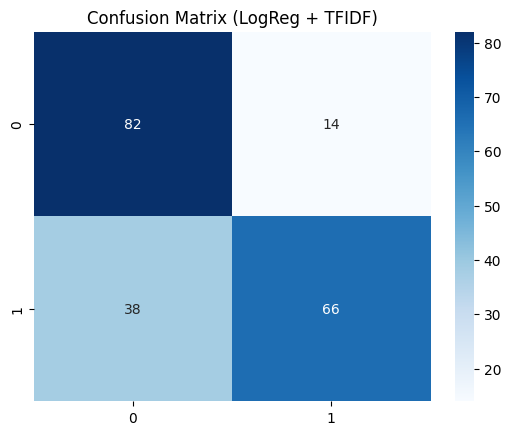

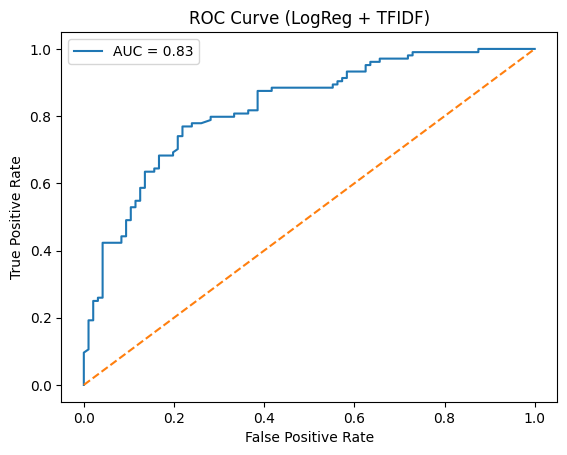

In [11]:
# Example: ROC Curve & Confusion Matrix for best model (LogReg + TFIDF)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

best_model = LogisticRegression()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix (LogReg + TFIDF)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LogReg + TFIDF)")
plt.legend()
plt.show()


In [22]:
"""
Gradio NLP Classification App
- Trains multiple classifiers on the Restaurant_Reviews.tsv dataset
- Supports BOW and TF-IDF vectorizers
- Provides a UI to pick vectorizer + model, enter review text, predict label & probability
- Shows evaluation metrics (5-fold stratified CV) for all models

How to run:
1. Install dependencies: pip install -r requirements.txt
   (requirements: scikit-learn, pandas, numpy, nltk, gradio, xgboost, lightgbm, joblib)
2. Update DATA_PATH below to point to your Restaurant_Reviews.tsv file
3. Run: python gradio_nlp_app.py

Notes:
- Training happens on app startup. For larger datasets consider training offline and loading serialized models.
"""

import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Vectorizers & model tools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import lightgbm as lgb
except Exception:
    lgb = None

# App UI
import gradio as gr
import joblib

# ----------------------------- USER CONFIG ---------------------------------
DATA_PATH = r'/content/Restaurant_Reviews.tsv'  # <-- update if needed
MAX_FEATURES = 3000
N_SPLITS = 5
RANDOM_STATE = 42
CACHE_DIR = 'model_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

# ----------------------------- NLTK SETUP ---------------------------------
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
PS = PorterStemmer()

# ----------------------------- HELPERS ------------------------------------

def preprocess_text(text: str) -> str:
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    words = text.split()
    words = [PS.stem(w) for w in words if w not in STOPWORDS]
    return ' '.join(words)


def load_and_preprocess(path):
    df = pd.read_csv(path, delimiter='\t', quoting=3)
    df = df.dropna(subset=['Review'])
    df['clean'] = df['Review'].apply(preprocess_text)
    X_texts = df['clean'].tolist()
    y = df['Liked'].values
    return X_texts, y, df


MODEL_LIBRARY = {}
VECTORS = {}


def build_vectorizers(texts):
    cv = CountVectorizer(max_features=MAX_FEATURES)
    tfidf = TfidfVectorizer(max_features=MAX_FEATURES)
    X_cv = cv.fit_transform(texts).astype(np.float32) # Convert to float32
    X_tfidf = tfidf.fit_transform(texts).astype(np.float32) # Convert to float32
    VECTORS['BOW'] = (cv, X_cv)
    VECTORS['TFIDF'] = (tfidf, X_tfidf)
    # persist vectorizers
    joblib.dump(cv, os.path.join(CACHE_DIR, 'vectorizer_bow.joblib'))
    joblib.dump(tfidf, os.path.join(CACHE_DIR, 'vectorizer_tfidf.joblib'))
    return VECTORS


def cross_validate_models(X, y, models, n_splits=N_SPLITS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    results = []
    for name, model in models.items():
        try:
            # Convert sparse matrix to dense for models that require it (like older LightGBM versions)
            X_dense = X.toarray() if hasattr(X, 'toarray') else X
            acc = cross_val_score(model, X_dense, y, cv=skf, scoring='accuracy', n_jobs=-1).mean()
            prec = cross_val_score(model, X_dense, y, cv=skf, scoring='precision', n_jobs=-1).mean()
            rec = cross_val_score(model, X_dense, y, cv=skf, scoring='recall', n_jobs=-1).mean()
            f1 = cross_val_score(model, X_dense, y, cv=skf, scoring='f1', n_jobs=-1).mean()
            # roc_auc may fail for non-prob models; wrap
            try:
                roc = cross_val_score(model, X_dense, y, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
            except Exception:
                roc = np.nan
        except Exception as e:
            acc = prec = rec = f1 = roc = np.nan
        results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC-AUC': roc})
    return pd.DataFrame(results)


def train_all_models(texts, y):
    # build vectorizers
    V = build_vectorizers(texts)
    models = get_models()

    # train models on both vectorizers and persist
    for vec_name, (vec, X) in V.items():
        for name, model in models.items():
            key = f"{vec_name}__{name}"
            print(f"Training {key} ...")
            clf = model.fit(X, y)
            MODEL_LIBRARY[key] = (vec, clf)
            joblib.dump((vec, clf), os.path.join(CACHE_DIR, f"{key}.joblib"))
    print('Training finished.')
    return MODEL_LIBRARY


# ----------------------------- BOOTSTRAP ----------------------------------
print('Loading dataset and training models. This may take a minute...')
texts, y, df_source = load_and_preprocess(DATA_PATH)
MODEL_LIBRARY = {}  # clear
MODEL_LIBRARY = train_all_models(texts, y)

# Precompute CV metrics for UI
print('Computing cross-validated metrics (this may take a bit)...')
cv_results = {}
models = get_models()
for vec_name, (vec, X) in VECTORS.items():
    df_res = cross_validate_models(X, y, models)
    cv_results[vec_name] = df_res
print('Ready.')

# ----------------------------- PREDICTION HELPERS -------------------------

def predict_single(input_text, vec_choice, model_choice):
    key = f"{vec_choice}__{model_choice}"
    if key not in MODEL_LIBRARY:
        return {'error': f'Model {key} not found. Try retraining.'}
    vec, clf = MODEL_LIBRARY[key]
    clean = preprocess_text(input_text)
    X = vec.transform([clean])

    # try predict_proba
    prob = None
    try:
        prob_arr = clf.predict_proba(X)[0]
        # if binary, show prob of positive class
        if len(prob_arr) == 2:
            prob = float(prob_arr[1])
        else:
            prob = prob_arr.tolist()
    except Exception:
        # fallback to decision_function -> sigmoid
        try:
            df = clf.decision_function(X)
            # convert to pseudo-proba
            prob = float(1/(1+np.exp(-df[0])))
        except Exception:
            prob = None

    pred = clf.predict(X)[0]
    return {'prediction': int(pred), 'probability': prob, 'clean': clean}


def retrain_and_evaluate():
    # retrain from source texts (in case user updated dataset)
    global MODEL_LIBRARY, VECTORS, cv_results
    texts_local = df_source['clean'].tolist()
    MODEL_LIBRARY = train_all_models(texts_local, y)

    # recompute cv metrics
    cv_results = {}
    models = get_models()
    for vec_name, (vec, X) in VECTORS.items():
        df_res = cross_validate_models(X, y, models)
        cv_results[vec_name] = df_res

    return "Retraining complete. Models updated."


# ----------------------------- GRADIO UI ----------------------------------

vectorizer_options = list(VECTORS.keys())
model_options = list(get_models().keys())

with gr.Blocks(title="NLP Classifier — BOW / TFIDF + multiple models") as demo:
    gr.Markdown("# NLP Classifier Playground\nChoose vectorizer and model, input a review, and get a prediction.\nModels trained on your dataset at app startup.")

    with gr.Row():
        with gr.Column(scale=2):
            txt_in = gr.Textbox(label='Enter review text', placeholder='Type a restaurant review...', lines=4)
            vec_dd = gr.Dropdown(vectorizer_options, label='Vectorizer (BOW / TFIDF)', value=vectorizer_options[0])
            model_dd = gr.Dropdown(model_options, label='Model', value=model_options[0])
            predict_btn = gr.Button('Predict')

            output_pred = gr.Textbox(label='Prediction (1 = Liked, 0 = Not Liked)')
            output_prob = gr.Textbox(label='Probability / Confidence (when available)')
            output_clean = gr.Textbox(label='Preprocessed text (for debugging)')

            retrain_btn = gr.Button('Retrain All Models (runs on server)')
            retrain_status = gr.Textbox(label='Retrain Status')

        with gr.Column(scale=1):
            gr.Markdown('## Cross-validated metrics (5-fold)')
            res_bow = gr.Dataframe(value=cv_results['BOW'].round(4), label='BOW Results')
            res_tfidf = gr.Dataframe(value=cv_results['TFIDF'].round(4), label='TFIDF Results')

    def on_predict(text, vec_choice, model_choice):
        out = predict_single(text, vec_choice, model_choice)
        if 'error' in out:
            return out['error'], '', ''
        return str(out['prediction']), str(out['probability']), out['clean']

    predict_btn.click(on_predict, inputs=[txt_in, vec_dd, model_dd], outputs=[output_pred, output_prob, output_clean])
    retrain_btn.click(lambda: retrain_and_evaluate(), outputs=[retrain_status])

    gr.Markdown('---')
    gr.Markdown('**Notes:** If you plan to deploy this app to a public server, training many models on startup can be slow — consider pretraining and loading serialized models instead.')

# Launch (change share=True if you want a public link)
if __name__ == '__main__':
    demo.launch(server_name='0.0.0.0', server_port=7860)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading dataset and training models. This may take a minute...
Training BOW__Logistic Regression ...
Training BOW__Naive Bayes ...
Training BOW__SVM (Linear) ...
Training BOW__SVM (RBF) ...
Training BOW__KNN ...
Training BOW__Decision Tree ...
Training BOW__Random Forest ...
Training BOW__XGBoost ...
Training BOW__LightGBM ...
[LightGBM] [Info] Number of positive: 500, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

KeyboardInterrupt: 